<a href="https://colab.research.google.com/github/NidaNabi/cnn_from_scratch/blob/main/cnnpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
class ConvolutionLayer:
    def __init__(self, kernel_num, kernel_size):
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
       
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size) / (kernel_size**2)

    def patches_generator(self, image):
        image_h, image_w = image.shape
        self.image = image
        for h in range(image_h-self.kernel_size+1):
            for w in range(image_w-self.kernel_size+1):
                patch = image[h:(h+self.kernel_size), w:(w+self.kernel_size)]
                yield patch, h, w
    
    def forward_prop(self, image):
        image_h, image_w = image.shape
        convolution_output = np.zeros((image_h-self.kernel_size+1, image_w-self.kernel_size+1, self.kernel_num))
        for patch, h, w in self.patches_generator(image):
            convolution_output[h,w] = np.sum(patch*self.kernels, axis=(1,2))
        return convolution_output
    
    def back_prop(self, dE_dY, alpha):
        dE_dk = np.zeros(self.kernels.shape)
        for patch, h, w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                dE_dk[f] += patch * dE_dY[h, w, f]
        self.kernels -= alpha*dE_dk
        return dE_dk


In [ ]:
class MaxPoolingLayer:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def patches_generator(self, image):
        output_h = image.shape[0] // self.kernel_size
        output_w = image.shape[1] // self.kernel_size
        self.image = image

        for h in range(output_h):
            for w in range(output_w):
                patch = image[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size), (w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
                yield patch, h, w

    def forward_prop(self, image):
        image_h, image_w, num_kernels = image.shape
        max_pooling_output = np.zeros((image_h//self.kernel_size, image_w//self.kernel_size, num_kernels))
        for patch, h, w in self.patches_generator(image):
            max_pooling_output[h,w] = np.amax(patch, axis=(0,1))
        return max_pooling_output

    def back_prop(self, dE_dY):
        dE_dk = np.zeros(self.image.shape)
        for patch,h,w in self.patches_generator(self.image):
            image_h, image_w, num_kernels = patch.shape
            max_val = np.amax(patch, axis=(0,1))

            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
                            dE_dk[h*self.kernel_size+idx_h, w*self.kernel_size+idx_w, idx_k] = dE_dY[h,w,idx_k]
            return dE_dk


In [ ]:
class SoftmaxLayer:
    def __init__(self, input_units, output_units):
        self.weight = np.random.randn(input_units, output_units)/input_units
        self.bias = np.zeros(output_units)

    def forward_prop(self, image):
        self.original_shape = image.shape 
        image_flattened = image.flatten()
        self.flattened_input = image_flattened 
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    def back_prop(self, dE_dY, alpha):
        for i, gradient in enumerate(dE_dY):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

           
            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

       
            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

          
            dE_dZ = gradient * dY_dZ

          
            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

           
            self.weight -= alpha*dE_dw
            self.bias -= alpha*dE_db

            return dE_dX.reshape(self.original_shape)

def CNN_forward(image, label, layers):
    output = image/255.
    for layer in layers:
        output = layer.forward_prop(output)
  
    loss = -np.log(output[label])
    accuracy = 1 if np.argmax(output) == label else 0
    return output, loss, accuracy

def CNN_backprop(gradient, layers, alpha=0.05):
    grad_back = gradient
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back


def CNN_training(image, label, layers, alpha=0.05):
   
    output, loss, accuracy = CNN_forward(image, label, layers)

  
    gradient = np.zeros(10)
    gradient[label] = -1/output[label]

    gradient_back = CNN_backprop(gradient, layers, alpha)

    return loss, accuracy

In [ ]:
import numpy as np

import tensorflow as tf

def main():

  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
  X_train = X_train[:5000]
  y_train = y_train[:5000]

  layers = [
    ConvolutionLayer(16,3), 
    MaxPoolingLayer(2),
    SoftmaxLayer(13*13*16, 10) 
    ] 

  for epoch in range(4):
    print('Epoch {} ->'.format(epoch+1))
  
    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]
  
    loss = 0
    accuracy = 0
    for i, (image, label) in enumerate(zip(X_train, y_train)):
      if i % 100 == 0:
        print("Step {}. For the last 100 steps: average loss {}, accuracy {}".format(i+1, loss/100, accuracy))
        loss = 0
        accuracy = 0
      loss_1, accuracy_1 = CNN_training(image, label, layers)
      loss += loss_1
      accuracy += accuracy_1
  
if __name__ == '__main__':
  main()
  
  

Epoch 1 ->
Step 1. For the last 100 steps: average loss 0.0, accuracy 0
Step 101. For the last 100 steps: average loss 1.7011401497323502, accuracy 47
Step 201. For the last 100 steps: average loss 1.1349088318888045, accuracy 60
Step 301. For the last 100 steps: average loss 1.0196926607571093, accuracy 75
Step 401. For the last 100 steps: average loss 0.7782645278762215, accuracy 78
Step 501. For the last 100 steps: average loss 0.7757236112260765, accuracy 72
Step 601. For the last 100 steps: average loss 0.6462324631261612, accuracy 82
Step 701. For the last 100 steps: average loss 0.46818440188619476, accuracy 87
Step 801. For the last 100 steps: average loss 0.5982121453800602, accuracy 85
Step 901. For the last 100 steps: average loss 0.6025854819841012, accuracy 82
Step 1001. For the last 100 steps: average loss 0.5804550149477031, accuracy 79
Step 1101. For the last 100 steps: average loss 0.3232015356616456, accuracy 88
Step 1201. For the last 100 steps: average loss 0.421672

epoch: 10, loss = 4047.6594
epoch: 20, loss = 2852.7334
epoch: 30, loss = 2038.1647
epoch: 40, loss = 1482.7622
epoch: 50, loss = 1103.9894
epoch: 60, loss = 845.6217
epoch: 70, loss = 669.3495
epoch: 80, loss = 549.0634
epoch: 90, loss = 466.9656
epoch: 100, loss = 410.9220


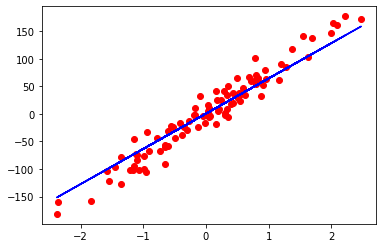

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt


X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)


X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape


input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)


learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


num_epochs = 100
for epoch in range(num_epochs):
  
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    
   
    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


predicted = model(X).detach().numpy()

plt.plot(X_numpy, y_numpy, 'ro')
plt.plot(X_numpy, predicted, 'b')
plt.show()
